In [2]:
import numpy as np
from eden import graph
from sklearn.decomposition import TruncatedSVD

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
import matplotlib
import umap
import utilities

from evaluator import Evaluator
from sklearn.neighbors import KNeighborsClassifier
import sklearn as sk
from sklearn.model_selection import train_test_split


# Load dataset generated using CFG

## Dataset generated from: 624249

In [3]:
import networkx as nx
def load_generated_data_classification(path):
    
    graphs = nx.read_gpickle(path+'/'+'graphs.gpickle')
    labels = list(np.load(path+'/'+'labels.npy'))
    
    return (graphs,labels)

def sub_sample(graphs,labels, n_graphs):
    
    graphs, labels = sk.utils.shuffle(graphs, labels)     
    return (graphs[0:n_graphs],labels[0:n_graphs])


def load_generated_data_regression(path):
    graphs = nx.read_gpickle(path+'/'+'graphs.gpickle')
    orig_graphs = nx.read_gpickle(path+'/'+'orig_graphs.gpickle')
    
    target_graph = nx.read_gpickle(path+'/'+'target_graphs.gpickle')
    reg_values = np.load(path+'/'+'regression_values.npy')
    
    return (graphs,orig_graphs,target_graph,reg_values)


In [74]:
#graphs, _, _, reg_values = load_generated_data_regression("generate_graphs/624249_graphs_reg_09_10000")
graphs, _, _, reg_values = load_generated_data_regression("generate_graphs/449764_graphs_reg_095_10000")


In [75]:
graphs, reg_values = sub_sample(graphs,reg_values,1000)

In [76]:
# prepross 
for g in graphs:
    for node in g.nodes():
        g.nodes[node]['vec'] = []
for g in graphs:
    for edge in g.edges():
        g.edges[edge]['vec'] = []

In [77]:
# ldp
functions = [utilities.degree,utilities.clust_coefficient,utilities.local_degree_profile]
graphs = utilities.add_info_to_nodes(graphs,functions)

max_n_nodes, n_attributes = utilities.find_shapes(graphs)

print("done")

done


In [78]:
graphs_train,graphs_test,reg_train,reg_test = train_test_split(graphs,reg_values,test_size=0.3)

In [79]:
vectoriz = graph.Vectorizer(complexity = 5)
data_train = vectoriz.transform(graphs_train)
data_test = vectoriz.transform(graphs_test)

# REGRESSION
# MODEL2: Vect -- PCA_500 -- AUTOENCODER_60 REG -- UMAP 2

In [80]:
from keras import Input
from keras.layers import Dense, Dropout
from keras import Model
from keras.initializers import RandomNormal
from keras.losses import mean_squared_error

from keras.callbacks import EarlyStopping, TensorBoard

In [81]:
pca_2 = TruncatedSVD(n_components=500)
m2_200_data_train = pca_2.fit(data_train).transform(data_train)
m2_200_data_test = pca_2.transform(data_test)

from embedder import Preprocessing_scaler
scaler = Preprocessing_scaler([0, 1])
m2_200_scal_data_train = scaler.fit(m2_200_data_train).transform(m2_200_data_train)
m2_200_scal_data_test = scaler.transform(m2_200_data_test)

from sklearn.preprocessing import Normalizer
normalizer = Normalizer(copy=True, norm='l2')  
m2_norm_data_train = normalizer.fit(m2_200_scal_data_train).transform(m2_200_scal_data_train)
m2_norm_data_test = normalizer.transform(m2_200_scal_data_test)

In [82]:
input_auto = len(m2_200_scal_data_train[0])
print(input_auto)

500


In [85]:
count = 45

#### define autoencoder

In [86]:
iniz = RandomNormal(mean=0, stddev=0.05)

prob_drop = 0.5
x_in = Input(shape=(input_auto,))
enc = Dense(input_auto*2, activation="relu",kernel_initializer=iniz)(x_in)
enc = Dropout(prob_drop)(enc)
enc = Dense(input_auto, activation="relu",kernel_initializer=iniz)(enc)
enc = Dense(60, activation="sigmoid",kernel_initializer=iniz)(enc)

decode = Dense(input_auto, activation="relu",name='decoder',kernel_initializer=iniz)(enc)

reg = Dense(10, activation='relu')(enc)
reg = Dense(1, activation='linear',name='regression')(reg)


sup_autoencoder = Model(inputs = x_in, outputs = [decode,reg])

sup_autoencoder.compile(optimizer='adam',
                    metrics={'decoder': 'mse', 'classifier': ['mse']},
                    loss = {'decoder': 'mean_squared_error', 'regression': 'mean_squared_error'},
                    loss_weights = {'decoder': 1, 'regression': 0.01})

In [87]:
path = "logs_reg/test_"+str(count)
count = count + 1
tb = TensorBoard(log_dir=path)
er = EarlyStopping(monitor='val_classifier_acc', patience=80, restore_best_weights=True)

sup_autoencoder.fit(m2_norm_data_train,
                    {'decoder': m2_norm_data_train, 'regression': reg_train},
                    epochs=500,    
                    verbose=0,
                    validation_split=0.2,
                    callbacks=[tb,er])



/home/antonio/anaconda3/envs/tesi/lib/python3.7/site-packages/keras/callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `val_classifier_acc` which is not available. Available metrics are: val_loss,val_decoder_loss,val_regression_loss,val_decoder_mean_squared_error,loss,decoder_loss,regression_loss,decoder_mean_squared_error
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


In [88]:
a = sup_autoencoder.evaluate(m2_norm_data_test,[m2_norm_data_test,reg_test])
n = sup_autoencoder.metrics_names
for i in range(0,len(a)):
    print(str(n[i])+" "+str(a[i]))

300/300 [==============================] - 0s 55us/step
loss 0.0009754489284629623
decoder_loss 0.0009659225276360909
regression_loss 0.0009526401245966554
decoder_mean_squared_error 0.0009659225276360909


In [89]:
pred_dec_train, pred_reg_train = sup_autoencoder.predict(m2_norm_data_train)
pred_dec_test, pred_reg_test = sup_autoencoder.predict(m2_norm_data_test)

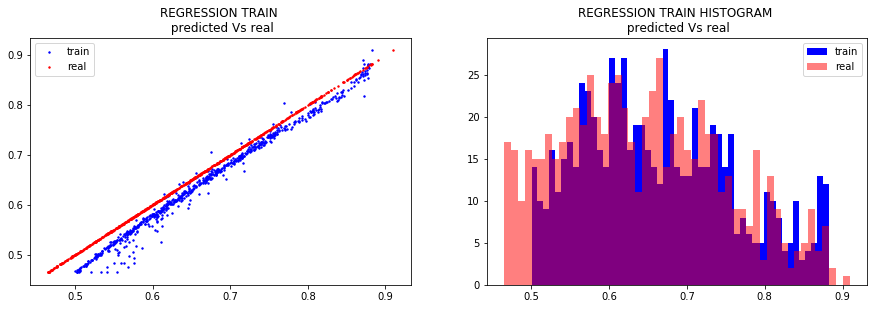

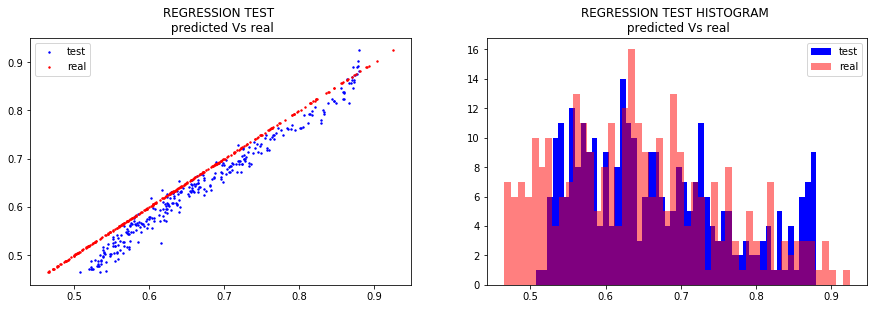

In [90]:
plot_regression(pred_reg_train,pred_reg_test,reg_train,reg_test)

DATA TRAIN


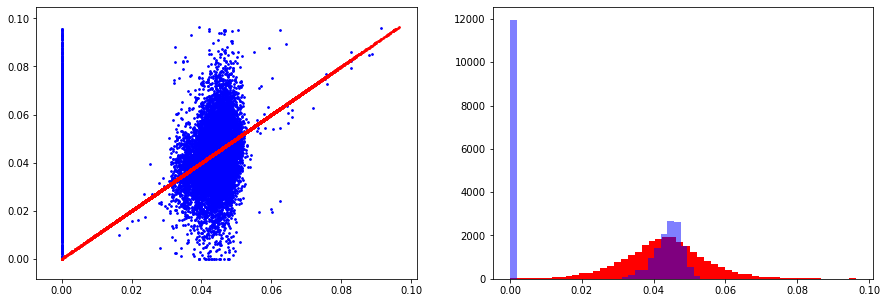


DATA TEST


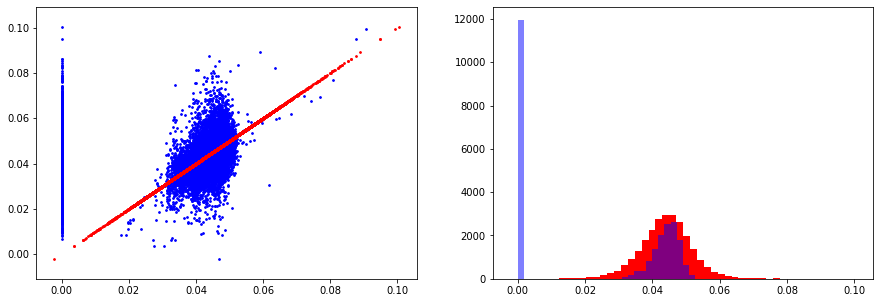

In [91]:
print("DATA TRAIN")
plot_autoencoder(m2_norm_data_train,pred_dec_train)
print("\nDATA TEST")
plot_autoencoder(m2_norm_data_test,pred_dec_test)

### non ho piu le classi quindi non ho bisogno di fare il train di UMAP

In [92]:
encoder_1 = Model(x_in, enc)
res_auto_train = encoder_1.predict(m2_norm_data_train)
res_auto_test = encoder_1.predict(m2_norm_data_test)

In [97]:
uma_2 = umap.UMAP(n_components=2)
res_m2_train = uma_2.fit(res_auto_train,reg_train).transform(res_auto_train)
res_m2_test = uma_2.transform(res_auto_test)

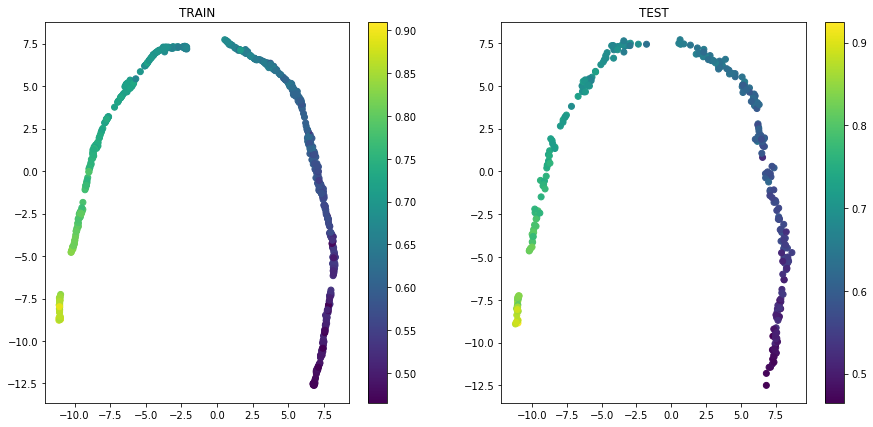

In [98]:
plot_embedding_reg(res_m2_test,res_m2_train,reg_test,reg_train)

In [53]:

def plot_embedding_reg(emb_test,emb_train,reg_test,reg_train):
    plt.figure(figsize=(15,7))
    plt.subplot(121)
    plt.title("TRAIN")
    xx = emb_train[:,0]
    yy = emb_train[:,1]
    b2 = plt.scatter(xx,yy,c=reg_train)
    plt.colorbar(b2)



    plt.subplot(122)
    plt.title("TEST")
    xx = emb_test[:,0]
    yy = emb_test[:,1]
    b1 = plt.scatter(xx,yy,c=reg_test)
    plt.colorbar(b1)
    plt.show()

def plot_autoencoder(orig_data_test,pred_data_test):
    pred_tmp = []
    real_tmp = []
    for i in range(50):
        p_tmp = pred_data_test[i]
        r_tmp = orig_data_test[i]
        for j in range(0,len(r_tmp)):
            pred_tmp.append(p_tmp[j])
            real_tmp.append(r_tmp[j])

    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.scatter(pred_tmp,real_tmp,c="b",s=3)
    plt.scatter(real_tmp,real_tmp,c="r",s=3)

    plt.subplot(122)
    plt.hist(real_tmp,color="r",bins=50)
    plt.hist(pred_tmp,color="b",bins=50,alpha=0.5)
    plt.show()
    
def plot_regression(pred_reg_train,pred_reg_test,reg_train,reg_test):
    plt.figure(figsize=(15,10))
    plt.subplot(221)
    plt.title("REGRESSION TRAIN \n predicted Vs real")
    plt.scatter(pred_reg_train,reg_train,s=2,c="b", label="train")
    plt.scatter(reg_train,reg_train,s = 2,c="r",label="real")
    plt.legend()

    plt.subplot(222)
    plt.title("REGRESSION TRAIN HISTOGRAM \n predicted Vs real")
    plt.hist(pred_reg_train,bins=50, color="b",label="train")
    plt.hist(reg_train,bins=50,alpha=0.5, color="r",label="real")
    plt.legend()
    plt.show()

    plt.figure(figsize=(15,10))
    plt.subplot(221)
    plt.title("REGRESSION TEST \n predicted Vs real")
    plt.scatter(pred_reg_test,reg_test,s=2,c="b", label="test")
    plt.scatter(reg_test,reg_test,s = 2,c='r',label="real")
    plt.legend()

    plt.subplot(222)
    plt.title("REGRESSION TEST HISTOGRAM \n predicted Vs real")
    plt.hist(pred_reg_test,bins=50, color="b",label="test")
    plt.hist(reg_test,bins=50,alpha=0.5, color="r",label="real")
    plt.legend()
    plt.show()
